# [MO443] Trabalho de Alinhamento de Documentos - Trabalho 03

> Trabalho realizado por Maria Angélica Krüger Miranda {197698}
>
> **Objetivo:** Implementar algoritmos de alinhamento automático de imagem de documentos

## Introdução

Um problema recorrente na análise de documentos advém do desalinhamento do texto, ou seja, quando ocorre o posicionamento da folha com uma inclinação diferente do digitalizador. Diante disso, é fundamental corrigir este problema para que sistemas de reconhecimento óptico de caracteres possam funcionar adequadamente.

Neste trabalho será explorado duas abordagens para corrigir o desalinhamento do texto. A primeira consiste na técnica de projeção horizontal e a outra na transformada de Hough. 

## Técnica Baseada em Projeção Horizontal

Esta técnica consiste variar o ângulo e projetar a quantidade de pixels pretos em cada linha do texto. O ângulo escolhido é aquele que otimiza uma certa função objetivo calculada sobre a projeção horizontal. 

Dada uma imagem que contém um texto desalinhado, o primeiro procedimento realizado será a binarização seguido da aplicação do efeito negativo na imagem, pois assim não haverá problemas com os diversos valores presentes na escala de cinza e também com o fundo preto que ficará aparente ao iniciar o processo de rotação, influenciando na contagem dos pixels pretos que pertencem aos caracteres do texto. 

O algoritmo para detectar a inclinação inicia-se percorrendo o eixo de angulação de $0$ a $180$, em que é realizado uma rotação com um determinado ângulo $\theta$ seguido do cálculo da projeção horizontal, que no caso, será a quantidade de pixels brancos, devido ao efeito negativo aplicado, presentes em cada linha da imagem. O melhor ângulo para rotacionar a imagem será aquele que produziu a menor quantidade de linhas com pixels pertencentes aos caracteres (iguais a 1), ou seja, que a maioria das linhas da imagem pertençam ao fundo. 

Nas células a seguir encontra-se os procedimentos mencionados anteriormente. Na primeira célula é realizada as importações das bibliotecas necessárias. Na célula subjacente, encontra-se três funções auxiliares, sendo duas que realizam a plotagem das imagens por intermédio da biblioteca *Matplotlib* e a terceira função realiza o procedimento de rotação de uma imagem com base em um ângulo. Por fim, a célula seguinte contém a função de detecção do ângulo de inclinação do texto via projeção horizontal. Nesta célula contém todo o algoritmo mencionado, iniciando com o processamento da imagem (binarização e aplicação do efeito negativo) seguido da descoberta do ângulo com a projeção horizontal de maneira iterativa e com base na quantidade de linhas com pixels pertencentes aos caracteres do texto.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [89]:
def mostrar_imagem(imagem, titulo, colorMap = None):
    if colorMap is not None:
        plt.imshow(imagem, cmap=colorMap)
    else:
        plt.imshow(imagem)
    plt.title(titulo)
    plt.axis('off')
    plt.show()
    
def produzir_subimagem(subimagem, i, j, imagem, color_map = None, titulo = None):
    if color_map is None:
        subimagem[i][j].imshow(imagem)
    else:
        subimagem[i][j].imshow(imagem, cmap=color_map)
    subimagem[i][j].set_title(titulo)
    subimagem[i][j].axis('off')
        

def rotacionar_imagem(imagem: np.ndarray, angulo: int):
    linhas, colunas = imagem.shape[0], imagem.shape[1]
    centro = (colunas//2, linhas//2)
    rotacao = cv2.getRotationMatrix2D(centro, angulo, 1.0)
    img_rotacionada = cv2.warpAffine(imagem, rotacao, (colunas, linhas))
    return img_rotacionada

def binarizar_imagem(imagem: np.ndarray, limiar: int):
    imagem_binarizada = np.where(imagem > limiar, 1, 0)
    return imagem_binarizada

In [94]:
def detectar_inclinacao_projecao_horizontal(imagem: np.ndarray, limiar: int):
    
    linhas, colunas = imagem.shape[0], imagem.shape[1]
    
    # Binarização da imagem por meio de um limiar
    img_binaria = binarizar_imagem(imagem, limiar)
    
    # Aplicação do efeito negativo na imagem
    img_negativa = np.zeros((linhas, colunas), dtype=np.uint8)
    img_negativa = 1 - img_binaria
    
    # Conversão de tipo para correto funcionamento na função de rotação
    img_binaria = img_binaria.astype(np.uint8)
    img_negativa = img_negativa.astype(np.uint8)
    
    # Algoritmo de detecção de inclinação
    melhor_angulo = -180
    melhor_projecao = np.inf

    for angulo in range(0,180):
        for sinal in range(-1, 2, 2):                                           # sinal -1 ou 1 -> evitar problemas de imagem virada de cabeça para baixo      
            # Rotaciona a imagem negativa com base num determinado ângulo
            img_rotacionada = rotacionar_imagem(img_negativa, angulo*sinal)     
            
            # Determina a projeção horizontal da imagem rotacionada
            projecao_horizontal = np.zeros((linhas), dtype=np.uint8)
            for i in range(linhas):
                projecao_horizontal[i] = np.sum(np.where(img_rotacionada[i] == 1, img_rotacionada[i], 0))
            
            # Realiza a verificação para ver se vai alterar o ângulo ou manter o mesmo     
            qtd_linhas_nao_zeradas = np.sum(np.where(projecao_horizontal > 30, 1, 0))
            if qtd_linhas_nao_zeradas < melhor_projecao:
                melhor_projecao = qtd_linhas_nao_zeradas
                melhor_angulo = angulo*sinal
                
    return melhor_angulo

A seguinte célula aplica a técnica baseada em projeção horizontal em diversas imagens e em seguida apresenta os resultados obtidos. Foi possível observar que das sete imagens apresentadas, cinco foram alinhadas corretamente e a técnica conseguiu corrigir o alinhamento tanto no sentido horário quanto anti-horário de rotação. As imagens de partitura e de documento completo não tiveram um bom desempenho, indicando que a técnica precisa de aperfeiçoamento. No caso do documento, um possível problema seja os recortes nas laterais cuja colaração é a mesma dos caracteres, contribuindo no momento da contagem. 

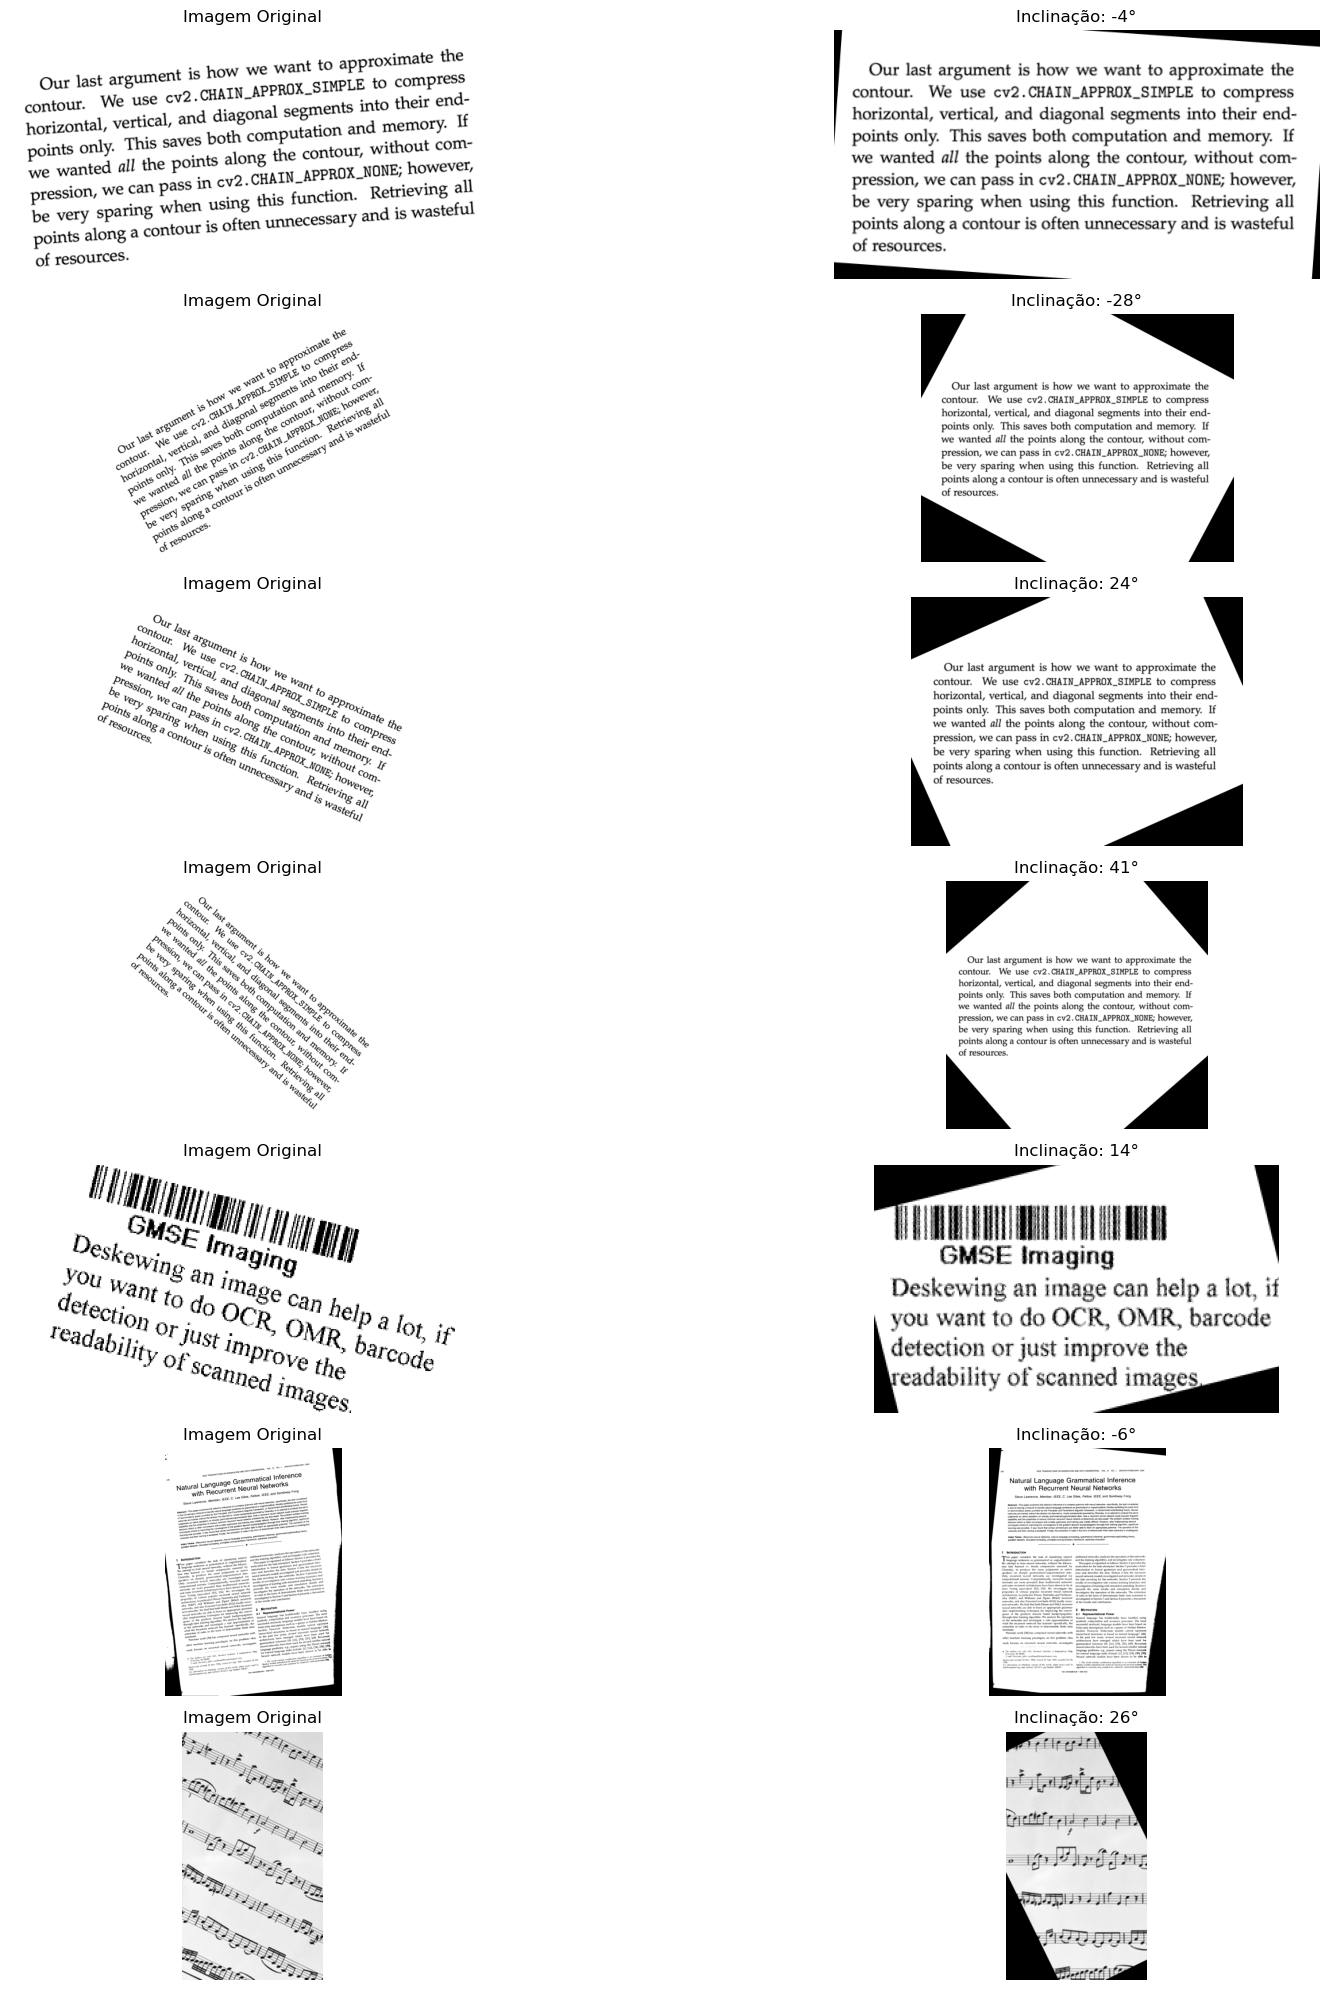

In [95]:
# Carregamento das imagens
img1 = cv2.imread('neg_4.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('neg_28.png', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('pos_24.png', cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread('pos_41.png', cv2.IMREAD_GRAYSCALE)
img5 = cv2.imread('sample1.png', cv2.IMREAD_GRAYSCALE)
img6 = cv2.imread('sample2.png', cv2.IMREAD_GRAYSCALE)
img7 = cv2.imread('partitura.png', cv2.IMREAD_GRAYSCALE)
imgs = [img1, img2, img3, img4, img5, img6, img7]

# Cálculo da inclinação das imagens 
angulo1 = detectar_inclinacao_projecao_horizontal(img1, 180)
angulo2 = detectar_inclinacao_projecao_horizontal(img2, 180)
angulo3 = detectar_inclinacao_projecao_horizontal(img3, 180)
angulo4 = detectar_inclinacao_projecao_horizontal(img4, 180)
angulo5 = detectar_inclinacao_projecao_horizontal(img5, 180)
angulo6 = detectar_inclinacao_projecao_horizontal(img6, 180)
angulo7 = detectar_inclinacao_projecao_horizontal(img7, 200)
angulos = [angulo1, angulo2, angulo3, angulo4, angulo5, angulo6, angulo7]

# Apresentação das imagens originais e rotacionadas
imagens = []
titulos = []
texto = 'Imagem Original'
texto_base = 'Inclinação: '
for i in range (0,7):
    imagens.append(imgs[i])
    imagens.append(rotacionar_imagem(imgs[i], angulos[i]))
    titulos.append(texto)
    titulos.append(texto_base + str(angulos[i]) + '°')
    
fig, subimagem = plt.subplots(7, 2, figsize=(20,20))
aux=0
for i in range(0,7):
    for j in range(0,2):
        produzir_subimagem(subimagem, i, j, imagens[aux], 'gray', titulos[aux])
        aux += 1
fig.tight_layout()
plt.show()

## Técnica Baseada na Transformada de Hough

A transformada de Hough baseia-se na ideia de representar qualquer linha por meio de dois parâmetros: a distância perpendicular da origem à reta, definida por $\rho$, e o ângulo $\theta$ formado por esta linha perpendicular com o eixo horizontal medido no sentido anti-horário. Desta forma é possível representar qualquer linha por meio de $(\rho, \theta)$. Para cada pixel da imagem é possível calcular os valores de $(\rho, \theta)$, criando um sistema de coordenadas polares onde cada ponto representa uma linha presente na imagem original. Sendo assim, a transformada de Hough converte a imagem em uma matriz de $(\rho, \theta)$, chamados de acumulador. O acumulador tem valores mais altos onde muitos pixels correspondem à mesma linha e valores baixos onde há menos concordância. 

A etapas que esta técnica necessita consiste numa conversão inicial das imagens para a escala de cinza, em seguida aplicar um algoritmo de detecção de bordas, que no caso será o algoritmo de Canny, e por fim calcular aplicar a transformada de Hough, calculando a matriz acumuladora. Como é desejado realizar a correção do alinhamento do documento, não basta apenas detectar as retas da imagem, então será calculado o coeficiente angular das retas conforme o algoritmo for encontrando-as. Dado o coeficiente de inclinação de todas as retas, basta calcular uma média destes e obter o ângulo para posteriormente realizar a rotação na imagem. 


In [87]:
def detectar_inclinacao_transformada_hough(imagem):
    angulo_rotacao = 0
    
    # Aplicação do detector de bordas de Canny
    img_borda = cv2.Canny(imagem, 50, 150)
    
    retas = cv2.HoughLines(img_borda, 1, np.pi/180, 100)
    angulos = []
    for linha in retas:
        rho, theta = linha[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        if x1 == x2:
            if y2 > y1:
                angulos.append(90)
            else:
                angulos.append(-90)
        else:
            m = (y2 - y1)/(x2 - x1)     # cálculo do coeficiente angular da reta
            angulo = np.arctan(m)       # cálculo do ângulo da reta -> m = tang(theta) -> ângulo devolvido em radianos
            angulos.append(angulo)
        
    angulo_rotacao = math.degrees(np.mean(angulos)) 
    
    return angulo_rotacao

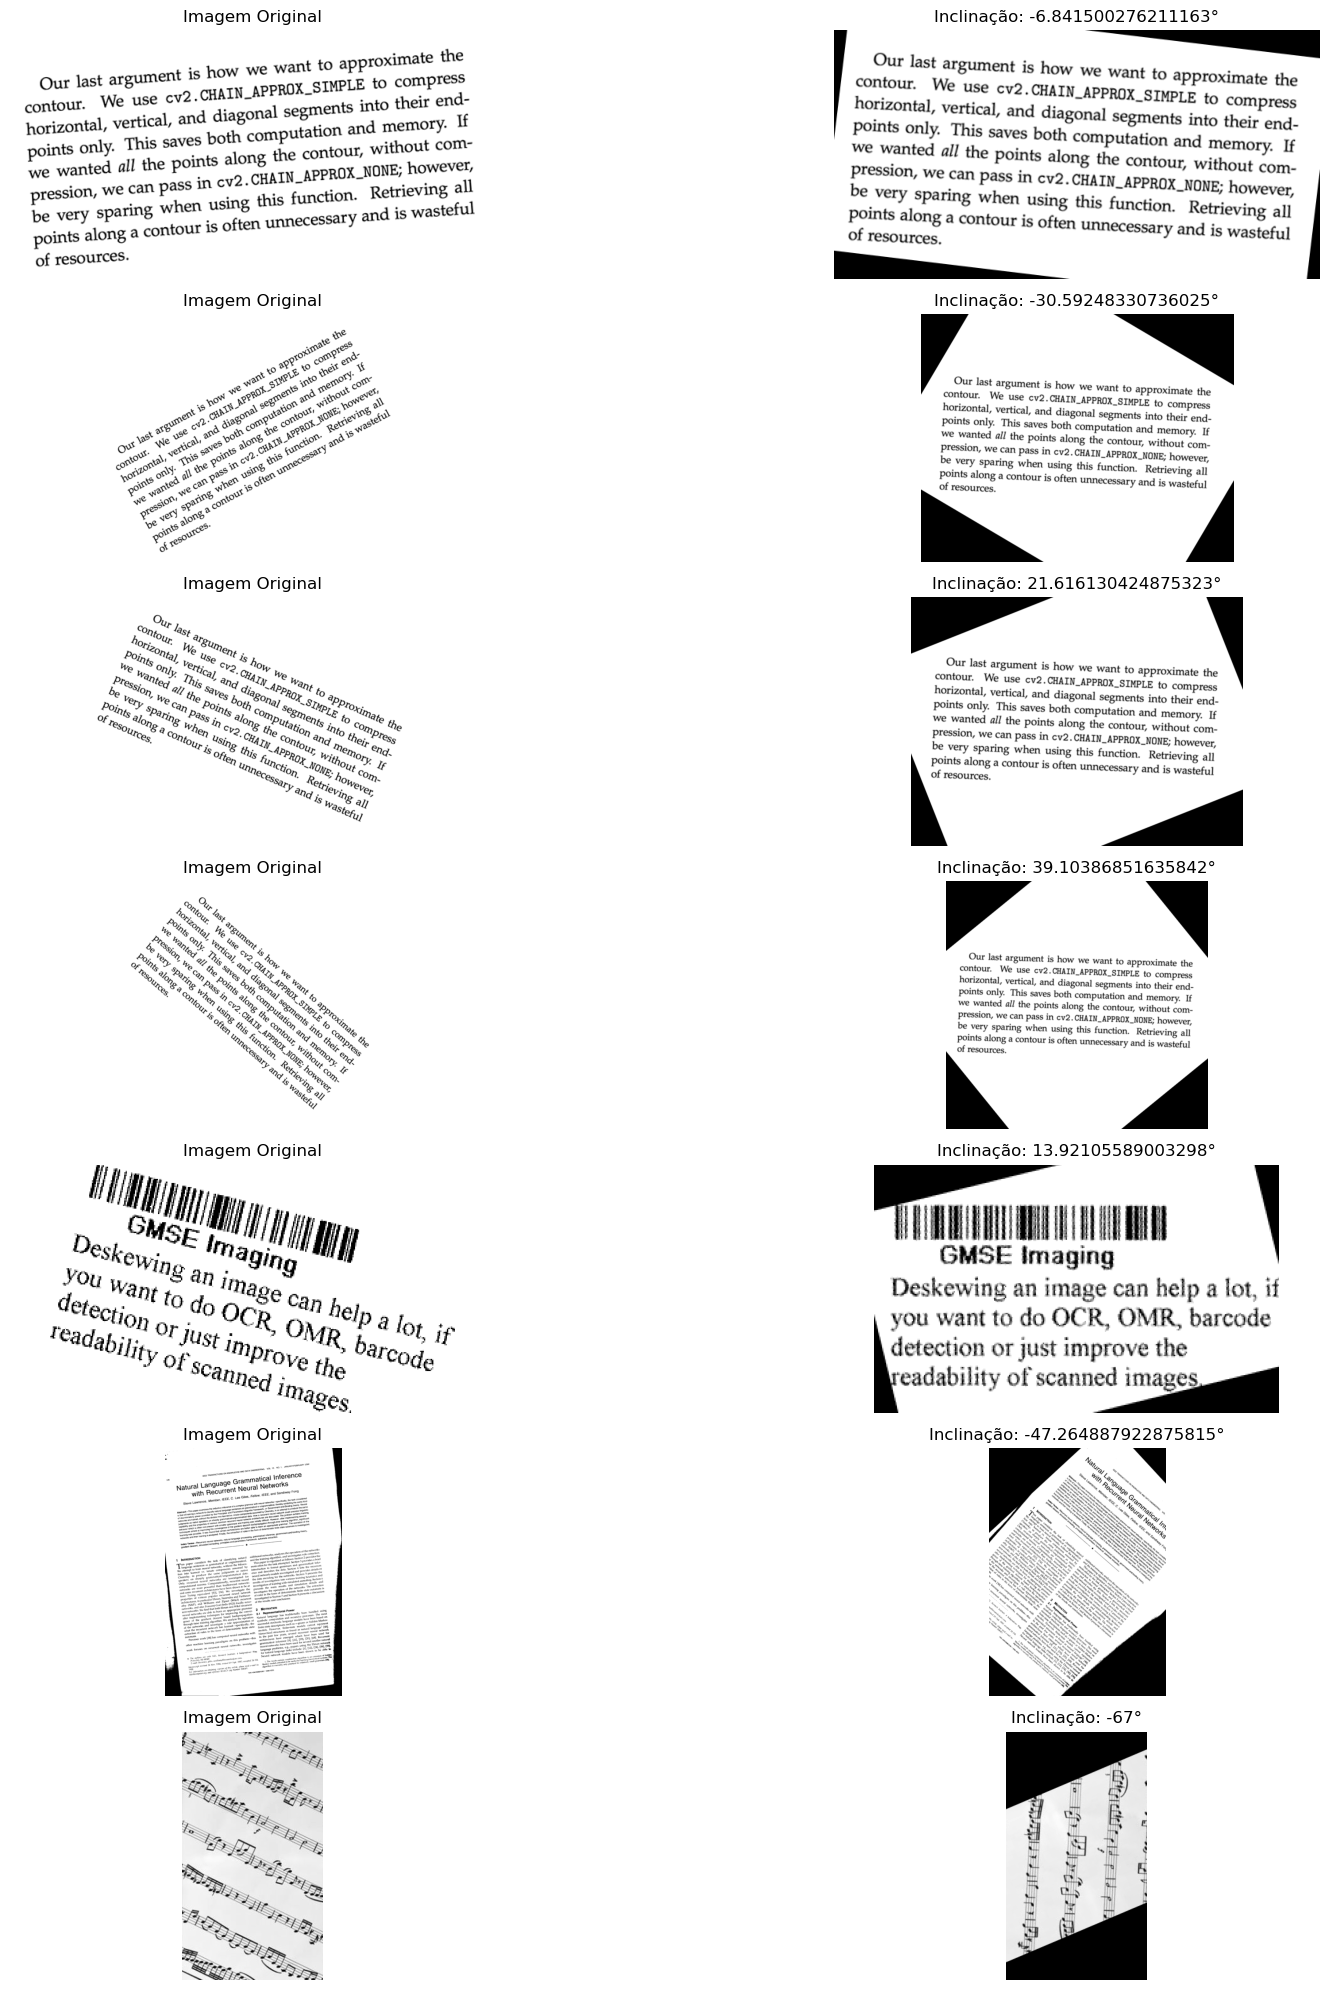

In [88]:
# Carregamento das imagens
img1 = cv2.imread('neg_4.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('neg_28.png', cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread('pos_24.png', cv2.IMREAD_GRAYSCALE)
img4 = cv2.imread('pos_41.png', cv2.IMREAD_GRAYSCALE)
img5 = cv2.imread('sample1.png', cv2.IMREAD_GRAYSCALE)
img6 = cv2.imread('sample2.png', cv2.IMREAD_GRAYSCALE)
img7 = cv2.imread('partitura.png', cv2.IMREAD_GRAYSCALE)
imgs = [img1, img2, img3, img4, img5, img6, img7]

# Cálculo da inclinação das imagens 
angulo1 = detectar_inclinacao_transformada_hough(img1)
angulo2 = detectar_inclinacao_transformada_hough(img2)
angulo3 = detectar_inclinacao_transformada_hough(img3)
angulo4 = detectar_inclinacao_transformada_hough(img4)
angulo5 = detectar_inclinacao_transformada_hough(img5)
angulo6 = detectar_inclinacao_transformada_hough(img6)
angulo7 = detectar_inclinacao_projecao_horizontal(img7)
angulos = [angulo1, angulo2, angulo3, angulo4, angulo5, angulo6, angulo7]

# Apresentação das imagens originais e rotacionadas
imagens = []
titulos = []
texto = 'Imagem Original'
texto_base = 'Inclinação: '
for i in range (0,7):
    imagens.append(imgs[i])
    imagens.append(rotacionar_imagem(imgs[i], angulos[i]))
    titulos.append(texto)
    titulos.append(texto_base + str(angulos[i]) + '°')
    
fig, subimagem = plt.subplots(7, 2, figsize=(20,20))
aux=0
for i in range(0,7):
    for j in range(0,2):
        produzir_subimagem(subimagem, i, j, imagens[aux], 'gray', titulos[aux])
        aux += 1
fig.tight_layout()
plt.show()

103.9375021096986
13.92105589003298


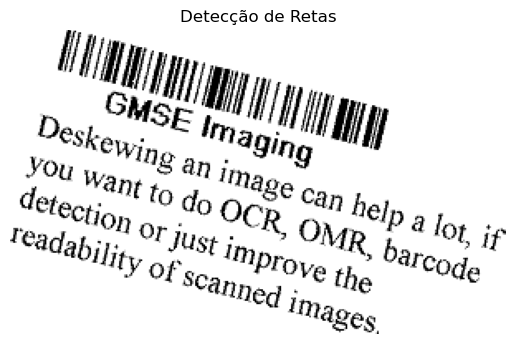

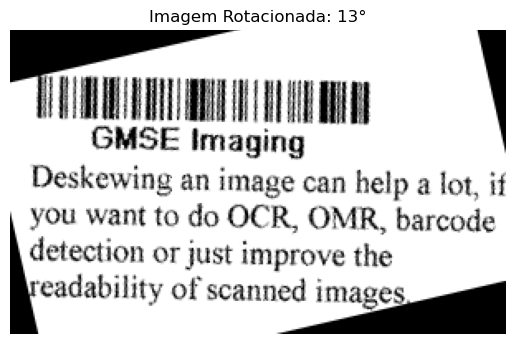

In [70]:
retas_alternativo = cv2.HoughLines(img_borda, 1, np.pi/180, 100)
#print(retas_alternativo)
#print(retas_alternativo.shape)
angulos = []
thetas = []
for linha in retas_alternativo:
    rho, theta = linha[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    thetas.append(theta)
    
    m = (y2 - y1)/(x2 - x1)
    angulo = np.arctan(m)
    angulos.append(angulo)
    
    #cv2.line(imagem, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
media_angulos = math.degrees(np.mean(angulos))  
media_thetas = math.degrees(np.mean(thetas))
print(media_thetas)  
print(media_angulos)
mostrar_imagem(imagem, 'Detecção de Retas', 'gray')
mostrar_imagem(rotacionar_imagem(imagem, int(media_angulos)), f'Imagem Rotacionada: {int(media_angulos)}°', 'gray')

In [ ]:
print(retas_alternativo)